In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import numpy as np
import glob

import os
from tqdm import tqdm


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- 1. BUILDING BLOCKS ---

class ResidualBlock(nn.Module):
    """Standard Residual Block"""
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# --- 2. THE BACKBONE (SHARED BRAIN) ---

class ResNetBackbone(nn.Module):
    """
    The feature extractor shared between Pre-training and Fine-tuning.
    Input: (B, 3, 64, 64) -> Output: (B, 512, 4, 4)
    """
    def __init__(self):
        super(ResNetBackbone, self).__init__()
        
        self.in_channels = 64
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # We define the layers but DO NOT add the pooling/flattening here yet
        # because the AutoEncoder needs the spatial map (4x4), not a vector.
        self.layer1 = self._make_layer(64, 2, stride=1)  # 64x64 -> 32x32 (actually stride 1 keeps size if not pooling, check block def)
        self.layer2 = self._make_layer(128, 2, stride=2) # 32x32 -> 16x16
        self.layer3 = self._make_layer(256, 2, stride=2) # 16x16 -> 8x8
        self.layer4 = self._make_layer(512, 2, stride=2) # 8x8 -> 4x4

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x # Returns shape (Batch, 512, 4, 4)

# --- 3. MODEL FOR STEP 1: SELF-SUPERVISED PRE-TRAINING ---

class InpaintingAutoEncoder(nn.Module):
    def __init__(self):
        super(InpaintingAutoEncoder, self).__init__()
        # Reuse the backbone as Encoder
        self.encoder = ResNetBackbone()
        
        # Decoder to reconstruct image from features
        # Input: (512, 4, 4) -> Output: (3, 64, 64)
        self.decoder = nn.Sequential(
            # 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            # 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            # 32x32 -> 64x64
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Sigmoid() # Output 0-1 for image
        )

    def forward(self, x):
        features = self.encoder(x)
        reconstructed = self.decoder(features)
        return reconstructed

# --- 4. MODEL FOR STEP 2: SUPERVISED FINE-TUNING ---

class CustomMultiHeadCNN(nn.Module):
    def __init__(self, n_color=5, n_length=3):
        super(CustomMultiHeadCNN, self).__init__()
        
        # Same backbone instance
        self.backbone = ResNetBackbone()
        
        # Pooling/Flattening specific to classification
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classification Heads
        feature_dim = 512
        
        self.head_beard = self._make_head(feature_dim, 1)
        self.head_mustache = self._make_head(feature_dim, 1)
        self.head_glasses = self._make_head(feature_dim, 1)
        self.head_color = self._make_head(feature_dim, n_color)
        self.head_length = self._make_head(feature_dim, n_length)

    def _make_head(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_dim, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, out_dim)
        )

    def forward(self, x):
        # Feature Extraction
        features_map = self.backbone(x) # (B, 512, 4, 4)
        features_vec = self.global_pool(features_map) # (B, 512, 1, 1)
        
        # Predictions
        return {
            "beard": self.head_beard(features_vec).squeeze(1),
            "mustache": self.head_mustache(features_vec).squeeze(1),
            "glasses": self.head_glasses(features_vec).squeeze(1),
            "hair_color": self.head_color(features_vec),
            "hair_length": self.head_length(features_vec)
        }

In [3]:
def preprocess_image(path, size=224):
    img = cv2.imread(path)
    if img is None:
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)[1]
    coords = cv2.findNonZero(thresh)
    if coords is None:
        return None
    x, y, w, h = cv2.boundingRect(coords)
    cropped = img[y:y+h, x:x+w]
    resized = cv2.resize(cropped, (size, size))
    return resized.astype("float32") / 255.0

DATA_DIR = "./data/raw/"

# Vérifier que le dossier existe
if not os.path.exists(DATA_DIR):
    print(f" Le dossier {DATA_DIR} n'existe pas!")
else:
    print(f" Le dossier {DATA_DIR} existe")
    
    # Lister le contenu du dossier
    print(f"Contenu du dossier: {os.listdir(DATA_DIR)[:10]}")  # Affiche les 10 premiers éléments
    
    # Chercher dans tous les sous-dossiers
    all_image_paths = glob.glob(os.path.join(DATA_DIR, "**", "*.png"), recursive=True)
    print(f"Trouvé {len(all_image_paths)} images PNG dans les sous-dossiers")
    
    # Si toujours 0, chercher d'autres extensions
    if len(all_image_paths) == 0:
        jpg_paths = glob.glob(os.path.join(DATA_DIR, "**", "*.jpg"), recursive=True)
        jpeg_paths = glob.glob(os.path.join(DATA_DIR, "**", "*.jpeg"), recursive=True)
        print(f"Trouvé {len(jpg_paths)} JPG et {len(jpeg_paths)} JPEG")
        all_image_paths = jpg_paths + jpeg_paths
    
    if len(all_image_paths) > 0:
        print(f"Premier chemin trouvé: {all_image_paths[0]}")

 Le dossier ./data/raw/ existe
Contenu du dossier: ['s1_04101.png', 's3_02923.png', 's2_04323.png', 's7_10377.png', 's2_05018.png', 's1_12714.png', 's6_14296.png', 's8_02414.png', 's7_01181.png', 's3_11318.png']
Trouvé 100000 images PNG dans les sous-dossiers
Premier chemin trouvé: ./data/raw/s1_04101.png


In [4]:
# ...existing code...
images_64 = []
processed_paths = []
for path in all_image_paths:   # all_image_paths already contains full relative paths under DATA_DIR
    img = preprocess_image(path, size=64)
    if img is None:
        continue
    images_64.append(img)
    processed_paths.append(path)

images_64 = np.array(images_64)
print("Loaded images:", images_64.shape, "from", len(processed_paths), "files")
# ...existing code...

Loaded images: (100000, 64, 64, 3) from 100000 files


In [8]:
# ...existing code...
output_dir = "data/processed/"
os.makedirs(output_dir, exist_ok=True)

for i, img_array in enumerate(images_64):
    original_filename = os.path.basename(processed_paths[i])
    if original_filename.endswith('.csv.png'):
        output_filename = original_filename.replace('.csv.png', '.png')
    else:
        output_filename = original_filename

    output_path = os.path.join(output_dir, output_filename)
    img_to_save = (img_array * 255).astype('uint8')
    cv2.imwrite(output_path, img_to_save)

print(f"Saved {len(images_64)} processed images to {output_dir}")
# ...existing code...

Saved 100000 processed images to data/processed/


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device : {device}")

Utilisation du device : cuda


In [9]:
class InpaintingDataset(Dataset):
    def __init__(self, image_dir, size=64, min_content_mean=0.02):
        import glob, cv2, numpy as np, os
        paths = glob.glob(os.path.join(image_dir, "**", "*.png"), recursive=True)
        paths += glob.glob(os.path.join(image_dir, "**", "*.jpg"), recursive=True)
        # filter out almost-empty/white images
        self.image_paths = []
        for p in paths:
            img_gray = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
            if img_gray is None:
                continue
            mean = img_gray.mean() / 255.0
            if mean < 1.0 - min_content_mean:
                self.image_paths.append(p)
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((size, size)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        import cv2, numpy as np
        p = self.image_paths[idx]
        img = cv2.imread(p)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_t = self.transform(img)            # original (target)
        inp = img_t.clone()
        # random square mask (you can vary shape/size)
        H = inp.shape[1]
        max_mask = int(H * 0.4)
        min_mask = max(4, int(H * 0.15))
        msize = np.random.randint(min_mask, max_mask + 1)
        x = np.random.randint(0, H - msize + 1)
        y = np.random.randint(0, H - msize + 1)
        inp[:, y:y+msize, x:x+msize] = 0.0
        return inp, img_t

In [13]:

# 3. Préparation des Données
print("Recherche des images...")

if len(all_image_paths) == 0:
    print("ERREUR: Aucune image trouvée ! Vérifiez le chemin '/content/dataset/'")
else:
    print(f"Trouvé {len(all_image_paths)} images pour le self-supervision.")

    # Création du ssl_loader
    processed_dir = "data/processed"
    ds = InpaintingDataset(processed_dir, size=64)
    print("usable images after filter:", len(ds))
    ssl_loader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
    sample_masked, sample_orig = next(iter(ssl_loader))
    # 4. Définition du Modèle (Auto-Encodeur)
    class AutoEncoder(nn.Module):
        def __init__(self):
            super(AutoEncoder, self).__init__()
            # Encodeur (Cerveau à transférer)
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 64, 3, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
                nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
                nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            )
            # Décodeur (Sert juste pour l'entraînement)
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(128), nn.ReLU(),
                nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(64), nn.ReLU(),
                nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),
                nn.Sigmoid() 
            )

        def forward(self, x):
            features = self.encoder(x)
            return self.decoder(features)

# 5. Lancement de l'Entraînement
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
# Utiliser un learning rate plus élevé avec scheduler
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

print(" Démarrage de l'entraînement Inpainting...")
torch.cuda.empty_cache()

# Ajouter early stopping
best_loss = float('inf')
patience = 10
patience_counter = 0

for epoch in range(100):
    model.train()
    total_loss = 0
    
    for masked_imgs, original_imgs in tqdm(ssl_loader, desc=f"Epoch {epoch+1}"):
        masked_imgs = masked_imgs.to(device, non_blocking=True)
        original_imgs = original_imgs.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)  # Plus efficace
        
        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            outputs = model(masked_imgs)
            loss = criterion(outputs, original_imgs)

        scaler.scale(loss).backward()
        # Gradient clipping pour stabilité
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(ssl_loader)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.6f}, LR = {scheduler.get_last_lr()[0]:.2e}")
    
    # Learning rate scheduling
    scheduler.step()
    
    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model.state_dict(), "autoencoder_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f" Early stopping à l'epoch {epoch+1}")
            break
    
    torch.cuda.empty_cache()
# 6. Sauvegarde
torch.save(model.encoder.state_dict(), "inpainting_encoder.pth")
print(" Encodeur pré-entraîné sauvegardé sous 'inpainting_encoder.pth'")
torch.save(model.state_dict(), "autoencoder_full.pth")
print(" Modèle complet sauvegardé")

Recherche des images...
Trouvé 100000 images pour le self-supervision.
usable images after filter: 100000


/tmp/ipykernel_84282/2801569389.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


 Démarrage de l'entraînement Inpainting...


Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]/tmp/ipykernel_84282/2801569389.py:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
Epoch 1: 100%|██████████| 1563/1563 [00:15<00:00, 99.94it/s] 


Epoch 1: Loss = 0.011086, LR = 5.00e-04


Epoch 2: 100%|██████████| 1563/1563 [00:16<00:00, 97.54it/s] 


Epoch 2: Loss = 0.005084, LR = 5.00e-04


Epoch 3: 100%|██████████| 1563/1563 [00:16<00:00, 97.53it/s] 


Epoch 3: Loss = 0.004482, LR = 5.00e-04


Epoch 4: 100%|██████████| 1563/1563 [00:16<00:00, 96.27it/s] 


Epoch 4: Loss = 0.004209, LR = 4.99e-04


Epoch 5: 100%|██████████| 1563/1563 [00:15<00:00, 100.60it/s]


Epoch 5: Loss = 0.003974, LR = 4.98e-04


Epoch 6: 100%|██████████| 1563/1563 [00:16<00:00, 96.53it/s] 


Epoch 6: Loss = 0.003817, LR = 4.97e-04


Epoch 7: 100%|██████████| 1563/1563 [00:15<00:00, 98.79it/s] 


Epoch 7: Loss = 0.003702, LR = 4.96e-04


Epoch 8: 100%|██████████| 1563/1563 [00:15<00:00, 98.03it/s] 


Epoch 8: Loss = 0.003580, LR = 4.94e-04


Epoch 9: 100%|██████████| 1563/1563 [00:15<00:00, 99.38it/s] 


Epoch 9: Loss = 0.003517, LR = 4.92e-04


Epoch 10: 100%|██████████| 1563/1563 [00:15<00:00, 99.63it/s] 


Epoch 10: Loss = 0.003427, LR = 4.90e-04


Epoch 11: 100%|██████████| 1563/1563 [00:15<00:00, 99.71it/s] 


Epoch 11: Loss = 0.003381, LR = 4.88e-04


Epoch 12: 100%|██████████| 1563/1563 [00:15<00:00, 97.82it/s] 


Epoch 12: Loss = 0.003301, LR = 4.85e-04


Epoch 13: 100%|██████████| 1563/1563 [00:15<00:00, 98.42it/s] 


Epoch 13: Loss = 0.003271, LR = 4.82e-04


Epoch 14: 100%|██████████| 1563/1563 [00:15<00:00, 98.81it/s] 


Epoch 14: Loss = 0.003223, LR = 4.79e-04


Epoch 15: 100%|██████████| 1563/1563 [00:15<00:00, 99.82it/s] 


Epoch 15: Loss = 0.003187, LR = 4.76e-04


Epoch 16: 100%|██████████| 1563/1563 [00:15<00:00, 98.06it/s] 


Epoch 16: Loss = 0.003166, LR = 4.73e-04


Epoch 17: 100%|██████████| 1563/1563 [00:16<00:00, 94.79it/s] 


Epoch 17: Loss = 0.003120, LR = 4.69e-04


Epoch 18: 100%|██████████| 1563/1563 [00:15<00:00, 98.26it/s] 


Epoch 18: Loss = 0.003082, LR = 4.65e-04


Epoch 19: 100%|██████████| 1563/1563 [00:16<00:00, 97.44it/s] 


Epoch 19: Loss = 0.003049, LR = 4.61e-04


Epoch 20: 100%|██████████| 1563/1563 [00:15<00:00, 98.14it/s] 


Epoch 20: Loss = 0.003031, LR = 4.57e-04


Epoch 21: 100%|██████████| 1563/1563 [00:15<00:00, 102.27it/s]


Epoch 21: Loss = 0.003014, LR = 4.52e-04


Epoch 22: 100%|██████████| 1563/1563 [00:15<00:00, 98.20it/s] 


Epoch 22: Loss = 0.002991, LR = 4.48e-04


Epoch 23: 100%|██████████| 1563/1563 [00:15<00:00, 98.41it/s] 


Epoch 23: Loss = 0.002960, LR = 4.43e-04


Epoch 24: 100%|██████████| 1563/1563 [00:16<00:00, 97.02it/s] 


Epoch 24: Loss = 0.002945, LR = 4.38e-04


Epoch 25: 100%|██████████| 1563/1563 [00:15<00:00, 100.73it/s]


Epoch 25: Loss = 0.002931, LR = 4.32e-04


Epoch 26: 100%|██████████| 1563/1563 [00:15<00:00, 98.73it/s] 


Epoch 26: Loss = 0.002911, LR = 4.27e-04


Epoch 27: 100%|██████████| 1563/1563 [00:15<00:00, 101.84it/s]


Epoch 27: Loss = 0.002888, LR = 4.21e-04


Epoch 28: 100%|██████████| 1563/1563 [00:16<00:00, 96.80it/s] 


Epoch 28: Loss = 0.002864, LR = 4.15e-04


Epoch 29: 100%|██████████| 1563/1563 [00:15<00:00, 100.70it/s]


Epoch 29: Loss = 0.002852, LR = 4.10e-04


Epoch 30: 100%|██████████| 1563/1563 [00:16<00:00, 96.31it/s] 


Epoch 30: Loss = 0.002838, LR = 4.03e-04


Epoch 31: 100%|██████████| 1563/1563 [00:16<00:00, 97.50it/s] 


Epoch 31: Loss = 0.002817, LR = 3.97e-04


Epoch 32: 100%|██████████| 1563/1563 [00:16<00:00, 92.02it/s] 


Epoch 32: Loss = 0.002810, LR = 3.91e-04


Epoch 33: 100%|██████████| 1563/1563 [00:17<00:00, 89.92it/s] 


Epoch 33: Loss = 0.002792, LR = 3.84e-04


Epoch 34: 100%|██████████| 1563/1563 [00:17<00:00, 90.73it/s] 


Epoch 34: Loss = 0.002780, LR = 3.78e-04


Epoch 35: 100%|██████████| 1563/1563 [00:17<00:00, 91.10it/s] 


Epoch 35: Loss = 0.002768, LR = 3.71e-04


Epoch 36: 100%|██████████| 1563/1563 [00:16<00:00, 94.26it/s] 


Epoch 36: Loss = 0.002753, LR = 3.64e-04


Epoch 37: 100%|██████████| 1563/1563 [00:15<00:00, 98.09it/s] 


Epoch 37: Loss = 0.002757, LR = 3.57e-04


Epoch 38: 100%|██████████| 1563/1563 [00:15<00:00, 100.45it/s]


Epoch 38: Loss = 0.002741, LR = 3.50e-04


Epoch 39: 100%|██████████| 1563/1563 [00:15<00:00, 98.21it/s] 


Epoch 39: Loss = 0.002719, LR = 3.42e-04


Epoch 40: 100%|██████████| 1563/1563 [00:16<00:00, 97.56it/s] 


Epoch 40: Loss = 0.002715, LR = 3.35e-04


Epoch 41: 100%|██████████| 1563/1563 [00:15<00:00, 98.05it/s] 


Epoch 41: Loss = 0.002716, LR = 3.28e-04


Epoch 42: 100%|██████████| 1563/1563 [00:15<00:00, 98.69it/s] 


Epoch 42: Loss = 0.002707, LR = 3.20e-04


Epoch 43: 100%|██████████| 1563/1563 [00:16<00:00, 97.22it/s] 


Epoch 43: Loss = 0.002693, LR = 3.13e-04


Epoch 44: 100%|██████████| 1563/1563 [00:15<00:00, 98.15it/s] 


Epoch 44: Loss = 0.002677, LR = 3.05e-04


Epoch 45: 100%|██████████| 1563/1563 [00:16<00:00, 96.43it/s] 


Epoch 45: Loss = 0.002666, LR = 2.97e-04


Epoch 46: 100%|██████████| 1563/1563 [00:16<00:00, 95.60it/s] 


Epoch 46: Loss = 0.002660, LR = 2.90e-04


Epoch 47: 100%|██████████| 1563/1563 [00:16<00:00, 96.13it/s] 


Epoch 47: Loss = 0.002645, LR = 2.82e-04


Epoch 48: 100%|██████████| 1563/1563 [00:16<00:00, 97.63it/s] 


Epoch 48: Loss = 0.002638, LR = 2.74e-04


Epoch 49: 100%|██████████| 1563/1563 [00:16<00:00, 93.69it/s] 


Epoch 49: Loss = 0.002639, LR = 2.66e-04


Epoch 50: 100%|██████████| 1563/1563 [00:16<00:00, 94.52it/s] 


Epoch 50: Loss = 0.002621, LR = 2.58e-04


Epoch 51: 100%|██████████| 1563/1563 [00:15<00:00, 100.53it/s]


Epoch 51: Loss = 0.002623, LR = 2.51e-04


Epoch 52: 100%|██████████| 1563/1563 [00:15<00:00, 99.98it/s] 


Epoch 52: Loss = 0.002612, LR = 2.43e-04


Epoch 53: 100%|██████████| 1563/1563 [00:16<00:00, 97.18it/s] 


Epoch 53: Loss = 0.002596, LR = 2.35e-04


Epoch 54: 100%|██████████| 1563/1563 [00:16<00:00, 96.83it/s] 


Epoch 54: Loss = 0.002592, LR = 2.27e-04


Epoch 55: 100%|██████████| 1563/1563 [00:16<00:00, 96.50it/s] 


Epoch 55: Loss = 0.002589, LR = 2.19e-04


Epoch 56: 100%|██████████| 1563/1563 [00:13<00:00, 112.77it/s]


Epoch 56: Loss = 0.002583, LR = 2.11e-04


Epoch 57: 100%|██████████| 1563/1563 [00:13<00:00, 114.47it/s]


Epoch 57: Loss = 0.002573, LR = 2.04e-04


Epoch 58: 100%|██████████| 1563/1563 [00:13<00:00, 112.55it/s]


Epoch 58: Loss = 0.002566, LR = 1.96e-04


Epoch 59: 100%|██████████| 1563/1563 [00:13<00:00, 116.47it/s]


Epoch 59: Loss = 0.002555, LR = 1.88e-04


Epoch 60: 100%|██████████| 1563/1563 [00:13<00:00, 113.72it/s]


Epoch 60: Loss = 0.002541, LR = 1.81e-04


Epoch 61: 100%|██████████| 1563/1563 [00:13<00:00, 114.13it/s]


Epoch 61: Loss = 0.002549, LR = 1.73e-04


Epoch 62: 100%|██████████| 1563/1563 [00:13<00:00, 115.05it/s]


Epoch 62: Loss = 0.002540, LR = 1.66e-04


Epoch 63: 100%|██████████| 1563/1563 [00:13<00:00, 116.06it/s]


Epoch 63: Loss = 0.002541, LR = 1.59e-04


Epoch 64: 100%|██████████| 1563/1563 [00:14<00:00, 107.80it/s]


Epoch 64: Loss = 0.002533, LR = 1.51e-04


Epoch 65: 100%|██████████| 1563/1563 [00:15<00:00, 101.31it/s]


Epoch 65: Loss = 0.002525, LR = 1.44e-04


Epoch 66: 100%|██████████| 1563/1563 [00:15<00:00, 99.58it/s] 


Epoch 66: Loss = 0.002515, LR = 1.37e-04


Epoch 67: 100%|██████████| 1563/1563 [00:15<00:00, 100.76it/s]


Epoch 67: Loss = 0.002516, LR = 1.30e-04


Epoch 68: 100%|██████████| 1563/1563 [00:15<00:00, 99.40it/s] 


Epoch 68: Loss = 0.002495, LR = 1.23e-04


Epoch 69: 100%|██████████| 1563/1563 [00:15<00:00, 98.60it/s] 


Epoch 69: Loss = 0.002503, LR = 1.17e-04


Epoch 70: 100%|██████████| 1563/1563 [00:15<00:00, 99.61it/s] 


Epoch 70: Loss = 0.002501, LR = 1.10e-04


Epoch 71: 100%|██████████| 1563/1563 [00:14<00:00, 108.91it/s]


Epoch 71: Loss = 0.002494, LR = 1.04e-04


Epoch 72: 100%|██████████| 1563/1563 [00:13<00:00, 116.15it/s]


Epoch 72: Loss = 0.002479, LR = 9.76e-05


Epoch 73: 100%|██████████| 1563/1563 [00:13<00:00, 114.62it/s]


Epoch 73: Loss = 0.002483, LR = 9.15e-05


Epoch 74: 100%|██████████| 1563/1563 [00:13<00:00, 115.55it/s]


Epoch 74: Loss = 0.002473, LR = 8.55e-05


Epoch 75: 100%|██████████| 1563/1563 [00:13<00:00, 117.37it/s]


Epoch 75: Loss = 0.002485, LR = 7.97e-05


Epoch 76: 100%|██████████| 1563/1563 [00:13<00:00, 117.51it/s]


Epoch 76: Loss = 0.002463, LR = 7.41e-05


Epoch 77: 100%|██████████| 1563/1563 [00:12<00:00, 120.28it/s]


Epoch 77: Loss = 0.002469, LR = 6.86e-05


Epoch 78: 100%|██████████| 1563/1563 [00:13<00:00, 113.74it/s]


Epoch 78: Loss = 0.002471, LR = 6.33e-05


Epoch 79: 100%|██████████| 1563/1563 [00:13<00:00, 112.39it/s]


Epoch 79: Loss = 0.002463, LR = 5.83e-05


Epoch 80: 100%|██████████| 1563/1563 [00:13<00:00, 114.71it/s]


Epoch 80: Loss = 0.002457, LR = 5.34e-05


Epoch 81: 100%|██████████| 1563/1563 [00:13<00:00, 114.87it/s]


Epoch 81: Loss = 0.002450, LR = 4.87e-05


Epoch 82: 100%|██████████| 1563/1563 [00:13<00:00, 116.36it/s]


Epoch 82: Loss = 0.002445, LR = 4.41e-05


Epoch 83: 100%|██████████| 1563/1563 [00:11<00:00, 136.82it/s]


Epoch 83: Loss = 0.002453, LR = 3.98e-05


Epoch 84: 100%|██████████| 1563/1563 [00:10<00:00, 155.65it/s]


Epoch 84: Loss = 0.002442, LR = 3.57e-05


Epoch 85: 100%|██████████| 1563/1563 [00:10<00:00, 155.89it/s]


Epoch 85: Loss = 0.002430, LR = 3.19e-05


Epoch 86: 100%|██████████| 1563/1563 [00:09<00:00, 156.38it/s]


Epoch 86: Loss = 0.002433, LR = 2.82e-05


Epoch 87: 100%|██████████| 1563/1563 [00:10<00:00, 155.38it/s]


Epoch 87: Loss = 0.002448, LR = 2.47e-05


Epoch 88: 100%|██████████| 1563/1563 [00:10<00:00, 154.66it/s]


Epoch 88: Loss = 0.002434, LR = 2.15e-05


Epoch 89: 100%|██████████| 1563/1563 [00:10<00:00, 155.64it/s]


Epoch 89: Loss = 0.002436, LR = 1.85e-05


Epoch 90: 100%|██████████| 1563/1563 [00:10<00:00, 155.27it/s]


Epoch 90: Loss = 0.002430, LR = 1.58e-05


Epoch 91: 100%|██████████| 1563/1563 [00:10<00:00, 155.75it/s]


Epoch 91: Loss = 0.002422, LR = 1.32e-05


Epoch 92: 100%|██████████| 1563/1563 [00:09<00:00, 156.78it/s]


Epoch 92: Loss = 0.002432, LR = 1.09e-05


Epoch 93: 100%|██████████| 1563/1563 [00:09<00:00, 158.14it/s]


Epoch 93: Loss = 0.002441, LR = 8.84e-06


Epoch 94: 100%|██████████| 1563/1563 [00:09<00:00, 159.18it/s]


Epoch 94: Loss = 0.002416, LR = 7.01e-06


Epoch 95: 100%|██████████| 1563/1563 [00:09<00:00, 158.29it/s]


Epoch 95: Loss = 0.002418, LR = 5.42e-06


Epoch 96: 100%|██████████| 1563/1563 [00:09<00:00, 157.97it/s]


Epoch 96: Loss = 0.002419, LR = 4.07e-06


Epoch 97: 100%|██████████| 1563/1563 [00:10<00:00, 156.15it/s]


Epoch 97: Loss = 0.002417, LR = 2.97e-06


Epoch 98: 100%|██████████| 1563/1563 [00:09<00:00, 157.15it/s]


Epoch 98: Loss = 0.002419, LR = 2.11e-06


Epoch 99: 100%|██████████| 1563/1563 [00:10<00:00, 156.28it/s]


Epoch 99: Loss = 0.002415, LR = 1.49e-06


Epoch 100: 100%|██████████| 1563/1563 [00:10<00:00, 153.63it/s]

Epoch 100: Loss = 0.002425, LR = 1.12e-06
 Encodeur pré-entraîné sauvegardé sous 'inpainting_encoder.pth'
 Modèle complet sauvegardé


In [25]:
# Ajouter après les imports existants
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import json

# 3. Préparation des Données (garder tel quel)
print("Recherche des images...")

if len(all_image_paths) == 0:
    print("ERREUR: Aucune image trouvée ! Vérifiez le chemin '/content/dataset/'")
else:
    print(f"Trouvé {len(all_image_paths)} images pour le self-supervision.")

    # Création du ssl_loader
    processed_dir = "data/processed"
    ds = InpaintingDataset(processed_dir, size=64)
    print("usable images after filter:", len(ds))
    ssl_loader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
    sample_masked, sample_orig = next(iter(ssl_loader))
    
    # 4. Définition du Modèle (garder tel quel)
    class AutoEncoder(nn.Module):
        def __init__(self):
            super(AutoEncoder, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 64, 3, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
                nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
                nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            )
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(128), nn.ReLU(),
                nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(64), nn.ReLU(),
                nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),
                nn.Sigmoid() 
            )

        def forward(self, x):
            features = self.encoder(x)
            return self.decoder(features)

    # 5. Fonction d'entraînement avec Hyperopt
    def train_model(params):
        """Fonction objectif pour Hyperopt"""
        print(f"\n Testing: LR={params['lr']:.2e}, WD={params['weight_decay']:.2e}, BS={params['batch_size']}")
        
        # Créer DataLoader avec batch_size optimisé
        loader = DataLoader(ds, batch_size=int(params['batch_size']), 
                          shuffle=True, num_workers=4, pin_memory=True)
        
        model = AutoEncoder().to(device)
        criterion = nn.MSELoss()
        optimizer = optim.AdamW(model.parameters(), 
                               lr=params['lr'], 
                               weight_decay=params['weight_decay'])
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)
        scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
        
        best_loss = float('inf')
        patience = 5
        patience_counter = 0
        
        # Entraînement court pour hyperopt (30 epochs max)
        for epoch in range(30):
            model.train()
            total_loss = 0
            
            for masked_imgs, original_imgs in loader:
                masked_imgs = masked_imgs.to(device, non_blocking=True)
                original_imgs = original_imgs.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                
                with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                    outputs = model(masked_imgs)
                    loss = criterion(outputs, original_imgs)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()

                total_loss += loss.item()

            avg_loss = total_loss / len(loader)
            scheduler.step()
            
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    break
            
            torch.cuda.empty_cache()
        
        print(f" Final loss: {best_loss:.6f}")
        return {'loss': best_loss, 'status': STATUS_OK}

    # Espace de recherche des hyperparamètres
    space = {
        'lr': hp.loguniform('lr', np.log(1e-4), np.log(1e-3)),
        'weight_decay': hp.loguniform('weight_decay', np.log(1e-5), np.log(1e-3)),
        'batch_size': hp.choice('batch_size', [32, 64, 128])
    }

    # Optimisation avec Hyperopt
    print("\n Démarrage de l'optimisation des hyperparamètres...")
    trials = Trials()
    best = fmin(
        fn=train_model,
        space=space,
        algo=tpe.suggest,
        max_evals=10,  # 10 configurations testées
        trials=trials
    )

    # Afficher les meilleurs hyperparamètres
    print("\n Meilleurs hyperparamètres trouvés:")
    print(f"Learning Rate: {best['lr']:.2e}")
    print(f"Weight Decay: {best['weight_decay']:.2e}")
    print(f"Batch Size: {[32, 64, 128][best['batch_size']]}")

    # Sauvegarder les résultats
    with open('src/model/best_hyperparams.json', 'w') as f:
        json.dump(best, f, indent=4)

    # 6. Entraînement final avec les meilleurs hyperparamètres
    print("\n Entraînement final avec les meilleurs hyperparamètres...")
    
    final_batch_size = [32, 64, 128][best['batch_size']]
    final_loader = DataLoader(ds, batch_size=final_batch_size, 
                             shuffle=True, num_workers=4, pin_memory=True)
    
    model = AutoEncoder().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), 
                           lr=best['lr'], 
                           weight_decay=best['weight_decay'])
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

    best_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(100):
        model.train()
        total_loss = 0
        
        for masked_imgs, original_imgs in tqdm(final_loader, desc=f"Epoch {epoch+1}"):
            masked_imgs = masked_imgs.to(device, non_blocking=True)
            original_imgs = original_imgs.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            
            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                outputs = model(masked_imgs)
                loss = criterion(outputs, original_imgs)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        avg_loss = total_loss / len(final_loader)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.6f}, LR = {scheduler.get_last_lr()[0]:.2e}")
        
        scheduler.step()
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            torch.save(model.state_dict(), "src/model/autoencoder_best.pth")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f" Early stopping à l'epoch {epoch+1}")
                break
        
        torch.cuda.empty_cache()

    # 7. Sauvegarde finale
    torch.save(model.encoder.state_dict(), "inpainting_encoder.pth")
    print(" Encodeur pré-entraîné sauvegardé sous 'inpainting_encoder.pth'")
    torch.save(model.state_dict(), "src/model/autoencoder_full.pth")
    print(" Modèle complet sauvegardé")

Recherche des images...
Trouvé 69069 images pour le self-supervision.
usable images after filter: 69069

🚀 Démarrage de l'optimisation des hyperparamètres...
                                                      
🔍 Testing: LR=6.85e-04, WD=5.44e-05, BS=32
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/tmp/ipykernel_32467/4007380891.py:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

/tmp/ipykernel_32467/4007380891.py:74: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):



  0%|          | 0/10 [01:17<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [26]:
# Ajouter après les imports existants
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import json
import mlflow
import mlflow.pytorch
from mlflow.tracking import MlflowClient

# Configuration MLflow
mlflow.set_tracking_uri("file:./mlruns")  # ou une URI distante
mlflow.set_experiment("autoencoder_inpainting")

# 3. Préparation des Données (garder tel quel)
print("🔍 Recherche des images...")

if len(all_image_paths) == 0:
    print("ERREUR: Aucune image trouvée ! Vérifiez le chemin '/content/dataset/'")
else:
    print(f"Trouvé {len(all_image_paths)} images pour le self-supervision.")

    # Création du ssl_loader
    processed_dir = "data/processed"
    ds = InpaintingDataset(processed_dir, size=64)
    print("usable images after filter:", len(ds))
    ssl_loader = DataLoader(ds, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
    sample_masked, sample_orig = next(iter(ssl_loader))
    
    # 4. Définition du Modèle (garder tel quel)
    class AutoEncoder(nn.Module):
        def __init__(self):
            super(AutoEncoder, self).__init__()
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 64, 3, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
                nn.Conv2d(64, 128, 3, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
                nn.Conv2d(128, 256, 3, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            )
            self.decoder = nn.Sequential(
                nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(128), nn.ReLU(),
                nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(64), nn.ReLU(),
                nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1),
                nn.Sigmoid() 
            )

        def forward(self, x):
            features = self.encoder(x)
            return self.decoder(features)

    # 5. Fonction d'entraînement avec Hyperopt + MLflow
    def train_model(params):
        """Fonction objectif pour Hyperopt avec logging MLflow"""
        
        # Démarrer un run MLflow pour chaque configuration
        with mlflow.start_run(nested=True):
            print(f"\n Testing: LR={params['lr']:.2e}, WD={params['weight_decay']:.2e}, BS={params['batch_size']}")
            
            # Logger les hyperparamètres
            mlflow.log_params({
                "lr": params['lr'],
                "weight_decay": params['weight_decay'],
                "batch_size": params['batch_size'],
                "optimizer": "AdamW",
                "scheduler": "CosineAnnealingLR",
                "max_epochs": 30,
                "patience": 5
            })
            
            # Créer DataLoader avec batch_size optimisé
            loader = DataLoader(ds, batch_size=int(params['batch_size']), 
                              shuffle=True, num_workers=4, pin_memory=True)
            
            model = AutoEncoder().to(device)
            criterion = nn.MSELoss()
            optimizer = optim.AdamW(model.parameters(), 
                                   lr=params['lr'], 
                                   weight_decay=params['weight_decay'])
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)
            scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
            
            best_loss = float('inf')
            patience = 5
            patience_counter = 0
            
            # Entraînement court pour hyperopt (30 epochs max)
            for epoch in range(30):
                model.train()
                total_loss = 0
                batch_losses = []
                
                for batch_idx, (masked_imgs, original_imgs) in enumerate(loader):
                    masked_imgs = masked_imgs.to(device, non_blocking=True)
                    original_imgs = original_imgs.to(device, non_blocking=True)

                    optimizer.zero_grad(set_to_none=True)
                    
                    with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                        outputs = model(masked_imgs)
                        loss = criterion(outputs, original_imgs)

                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    scaler.step(optimizer)
                    scaler.update()

                    batch_losses.append(loss.item())
                    total_loss += loss.item()

                avg_loss = total_loss / len(loader)
                current_lr = scheduler.get_last_lr()[0]
                
                # Logger les métriques par epoch
                mlflow.log_metrics({
                    "train_loss": avg_loss,
                    "learning_rate": current_lr,
                    "best_loss": best_loss,
                    "patience_counter": patience_counter
                }, step=epoch)
                
                scheduler.step()
                
                if avg_loss < best_loss:
                    best_loss = avg_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        mlflow.log_param("stopped_epoch", epoch)
                        break
                
                torch.cuda.empty_cache()
            
            # Logger le résultat final
            mlflow.log_metric("final_loss", best_loss)
            
            print(f" Final loss: {best_loss:.6f}")
            return {'loss': best_loss, 'status': STATUS_OK}

    # Espace de recherche des hyperparamètres
    space = {
        'lr': hp.loguniform('lr', np.log(1e-4), np.log(1e-3)),
        'weight_decay': hp.loguniform('weight_decay', np.log(1e-5), np.log(1e-3)),
        'batch_size': hp.choice('batch_size', [32, 64, 128])
    }

    # Optimisation avec Hyperopt + MLflow parent run
    print("\n Démarrage de l'optimisation des hyperparamètres...")
    
    with mlflow.start_run(run_name="hyperopt_optimization"):
        mlflow.log_param("hyperopt_max_evals", 10)
        mlflow.log_param("hyperopt_algo", "tpe")
        
        trials = Trials()
        best = fmin(
            fn=train_model,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials
        )

        # Logger les meilleurs hyperparamètres
        best_params = {
            "best_lr": best['lr'],
            "best_weight_decay": best['weight_decay'],
            "best_batch_size": [32, 64, 128][best['batch_size']]
        }
        mlflow.log_params(best_params)
        
        # Afficher les meilleurs hyperparamètres
        print("\nMeilleurs hyperparamètres trouvés:")
        print(f"Learning Rate: {best['lr']:.2e}")
        print(f"Weight Decay: {best['weight_decay']:.2e}")
        print(f"Batch Size: {[32, 64, 128][best['batch_size']]}")

        # Sauvegarder les résultats
        os.makedirs('src/model', exist_ok=True)
        with open('src/model/best_hyperparams.json', 'w') as f:
            json.dump(best_params, f, indent=4)
        mlflow.log_artifact('src/model/best_hyperparams.json')

    # 6. Entraînement final avec les meilleurs hyperparamètres
    print("\n Entraînement final avec les meilleurs hyperparamètres...")
    
    with mlflow.start_run(run_name="final_training"):
        final_batch_size = [32, 64, 128][best['batch_size']]
        
        # Logger la configuration finale
        mlflow.log_params({
            "lr": best['lr'],
            "weight_decay": best['weight_decay'],
            "batch_size": final_batch_size,
            "optimizer": "AdamW",
            "scheduler": "CosineAnnealingLR",
            "max_epochs": 100,
            "patience": 10,
            "dataset_size": len(ds)
        })
        
        final_loader = DataLoader(ds, batch_size=final_batch_size, 
                                 shuffle=True, num_workers=4, pin_memory=True)
        
        model = AutoEncoder().to(device)
        criterion = nn.MSELoss()
        optimizer = optim.AdamW(model.parameters(), 
                               lr=best['lr'], 
                               weight_decay=best['weight_decay'])
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)
        scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

        best_loss = float('inf')
        patience = 10
        patience_counter = 0

        for epoch in range(100):
            model.train()
            total_loss = 0
            
            for masked_imgs, original_imgs in tqdm(final_loader, desc=f"Epoch {epoch+1}"):
                masked_imgs = masked_imgs.to(device, non_blocking=True)
                original_imgs = original_imgs.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)
                
                with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                    outputs = model(masked_imgs)
                    loss = criterion(outputs, original_imgs)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()

                total_loss += loss.item()

            avg_loss = total_loss / len(final_loader)
            current_lr = scheduler.get_last_lr()[0]
            
            print(f"Epoch {epoch+1}: Loss = {avg_loss:.6f}, LR = {current_lr:.2e}")
            
            # Logger les métriques
            mlflow.log_metrics({
                "train_loss": avg_loss,
                "learning_rate": current_lr,
                "best_loss": best_loss,
                "patience_counter": patience_counter
            }, step=epoch)
            
            scheduler.step()
            
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
                torch.save(model.state_dict(), "src/model/autoencoder_best.pth")
                
                # Logger le modèle intermédiaire
                mlflow.pytorch.log_model(model, "best_model")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f" Early stopping à l'epoch {epoch+1}")
                    mlflow.log_param("stopped_epoch", epoch+1)
                    break
            
            torch.cuda.empty_cache()

        # 7. Sauvegarde finale
        torch.save(model.encoder.state_dict(), "inpainting_encoder.pth")
        torch.save(model.state_dict(), "src/model/autoencoder_full.pth")
        
        # Logger les artefacts finaux
        mlflow.log_artifact("inpainting_encoder.pth")
        mlflow.log_artifact("src/model/autoencoder_full.pth")
        mlflow.pytorch.log_model(model, "final_model")
        
        # Logger les métriques finales
        mlflow.log_metrics({
            "final_train_loss": best_loss,
            "total_epochs": epoch + 1
        })
        
        print(" Encodeur pré-entraîné sauvegardé sous 'inpainting_encoder.pth'")
        print(" Modèle complet sauvegardé")
        print(f" MLflow run ID: {mlflow.active_run().info.run_id}")

2025/12/02 03:09:50 INFO mlflow.tracking.fluent: Experiment with name 'autoencoder_inpainting' does not exist. Creating a new experiment.


🔍 Recherche des images...
Trouvé 69069 images pour le self-supervision.
usable images after filter: 69069

🚀 Démarrage de l'optimisation des hyperparamètres...
                                                      
🔍 Testing: LR=2.89e-04, WD=7.79e-04, BS=32
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/tmp/ipykernel_32467/3607511231.py:78: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

/tmp/ipykernel_32467/3607511231.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):



  0%|          | 0/10 [03:33<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

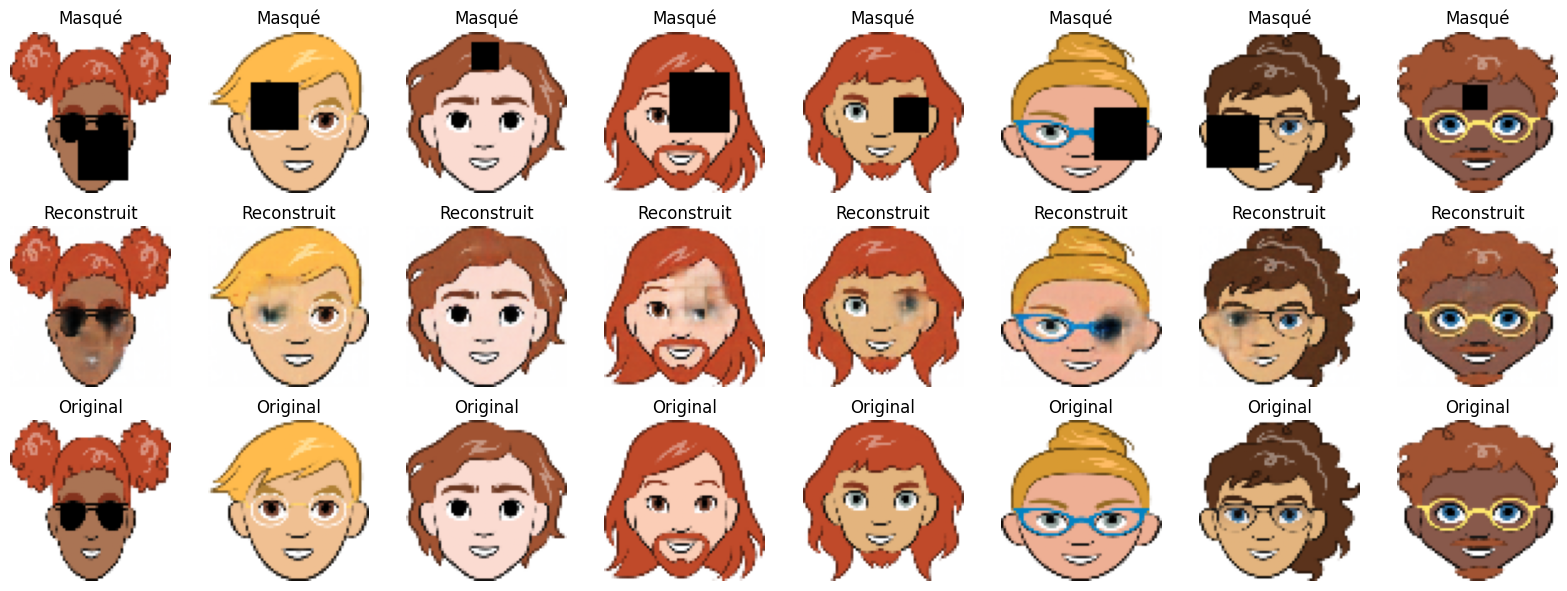

In [15]:

import matplotlib.pyplot as plt

model.eval()
sample_batch = next(iter(ssl_loader))
masked, original = sample_batch
masked = masked[:8].to(device)
original = original[:8].to(device)

with torch.no_grad():
    reconstructed = model(masked)

# Visualisation
fig, axes = plt.subplots(3, 8, figsize=(16, 6))
for i in range(8):
    axes[0, i].imshow(masked[i].cpu().permute(1, 2, 0))
    axes[0, i].set_title("Masqué")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(reconstructed[i].cpu().permute(1, 2, 0))
    axes[1, i].set_title("Reconstruit")
    axes[1, i].axis('off')
    
    axes[2, i].imshow(original[i].cpu().permute(1, 2, 0))
    axes[2, i].set_title("Original")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


In [18]:
# Nouvelle cellule - Transfer Learning

import torch

# Charger le modèle de classification
classifier = CustomMultiHeadCNN(n_color=5, n_length=3).to(device)

# Charger les poids pré-entraînés de l'encodeur
pretrained_encoder = torch.load("inpainting_encoder.pth", map_location=device)

# Mapper les poids vers le backbone du classifier
# L'encodeur de l'AutoEncoder a la même structure que les 3 premières couches
backbone_state = classifier.backbone.state_dict()

# Afficher les clés pour vérifier la correspondance
print("Clés de l'encodeur pré-entraîné:")
for k in pretrained_encoder.keys():
    print(f"  {k}")

print("\nClés du backbone classifier:")
for k in backbone_state.keys():
    print(f"  {k}")

# Note: Les architectures sont différentes, vous devrez adapter le mapping


Clés de l'encodeur pré-entraîné:
  0.weight
  0.bias
  1.weight
  1.bias
  1.running_mean
  1.running_var
  1.num_batches_tracked
  3.weight
  3.bias
  4.weight
  4.bias
  4.running_mean
  4.running_var
  4.num_batches_tracked
  6.weight
  6.bias
  7.weight
  7.bias
  7.running_mean
  7.running_var
  7.num_batches_tracked

Clés du backbone classifier:
  initial_conv.0.weight
  initial_conv.1.weight
  initial_conv.1.bias
  initial_conv.1.running_mean
  initial_conv.1.running_var
  initial_conv.1.num_batches_tracked
  layer1.0.conv1.weight
  layer1.0.bn1.weight
  layer1.0.bn1.bias
  layer1.0.bn1.running_mean
  layer1.0.bn1.running_var
  layer1.0.bn1.num_batches_tracked
  layer1.0.conv2.weight
  layer1.0.bn2.weight
  layer1.0.bn2.bias
  layer1.0.bn2.running_mean
  layer1.0.bn2.running_var
  layer1.0.bn2.num_batches_tracked
  layer1.1.conv1.weight
  layer1.1.bn1.weight
  layer1.1.bn1.bias
  layer1.1.bn1.running_mean
  layer1.1.bn1.running_var
  layer1.1.bn1.num_batches_tracked
  layer1.1.c